# Проект: Рынок заведений общественного питания Москвы

## Описание проекта

Исследование рынка общественного питания Москвы для ответа на вопрос о целесообразности открытия роботизированного кафе.

## Подготовка данных

In [16]:
# импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from io import BytesIO
import requests
import json

# настройка стиля графиков
plt.style.use('seaborn')

### Загрузка данных

Согласно предоставленой документации набор данных `rest_data` имеет следующую структуру:
* id — идентификатор объекта
* object_name — название объекта общественного питания
* chain — сетевой ресторан
* object_type — тип объекта общественного питания
* address — адрес
* number — количество посадочных мест

In [17]:
# выполним загрузку данных и посмотрим, что получилось
rest_data = pd.read_csv('/datasets/rest_data.csv')
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


На первый взгляд загруженный набор данных соответствует описанию. Колонки названы в соответствии со snake_case. Исследуем датасет поподробнее:
* проверим наличие пропусков и дубликатов
* проверим тим данных в каждой колонке

In [18]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропусков данных нет. Колонки `id` и `number` имеют целочисленный тип - это правильно, остальные строковый - что тоже хорошо.

### Поиск явных дубликатов

In [19]:
# проверим наличие дубликатов в колонке id.
print(f'Число дубликатов: {rest_data["id"].duplicated().sum()}')

Число дубликатов: 0


Явных дубликатов среди идетификаторов нет.

In [20]:
# посмотрим, что в столбце 'chain'
print('Количество заведений, отмеченных как не сетевые и как сетевые')
print(rest_data['chain'].value_counts())

Количество заведений, отмеченных как не сетевые и как сетевые
нет    12398
да      2968
Name: chain, dtype: int64


Только 'да' или 'нет', хорошо. Большее число заведений, вроде бы, не сетевые.
Так как значение булево, то для удобства заменим на 0 и 1.

In [21]:
rest_data['chain'] = rest_data['chain'].apply(lambda x: 1 if x=='да' else 0)

### Поиск неявных дубликатов

#### Столбец `object_name`

Для удобства работы с названиями заведений выполним со столбцом некоторые манипуляции.

In [22]:
# приведём все названия к нижнему регистру,
rest_data['object_name'] = rest_data['object_name'].str.lower()

# уберём знаки препинания,
# обеспечим единообразие записи,
replace_dict = {'.':' ',
                ',':' ',
                '-':' ',
                '&':' and ',
                '№':' № '}                            
                            
for key, value in replace_dict.items():
    rest_data['object_name'] = rest_data['object_name'].str.replace(key, value)                        

# убираем лишние пробелы                            
rest_data['object_name'] = rest_data['object_name'].apply(lambda x: ' '.join(x.split()))

**Допущение №1**

В принципе 2 заведения - это уже сеть, но так как у нас проблемы с данными, то примем, что сеть у нас будет состоять минимум из трёх заведений

In [23]:
# функция выводит информацию по датафрейму, принимая также наличие или отсутствие признака сети

def chain_data(df, is_chain=True):
    if is_chain:
        chain = df[df['chain'] == 1]['object_name'].value_counts()
        print(f'Сети, представленные в единственном экземпляре: {chain[chain < 3].count()}')
        print()
        print(f'Сети с не менее чем одним филиалом: {chain[chain >= 3].count()}')
        print(f'Количество сетевых заведений с не менее чем одним филиалом: {chain[chain >= 3].sum()}')
    else:
        chain = df[df['chain'] == 0]['object_name'].value_counts()
        print(f'Не сети, представленные в единственном экземпляре: {chain[chain < 3].count()}')
        print()
        print(f'Не сети с не менее чем одним филиалом: {chain[chain >= 3].count()}')
        print(f'Количество несетевых заведений с не менее чем одним филиалом: {chain[chain >= 3].sum()}')

In [24]:
# данные по заведениям, обозначеным как "сетевое"
chain_data(rest_data)

Сети, представленные в единственном экземпляре: 404

Сети с не менее чем одним филиалом: 167
Количество сетевых заведений с не менее чем одним филиалом: 2483


In [25]:
rest_data[rest_data['chain'] == 1]['object_name'].value_counts()[-30:-20]

семейное кафе андерсон          1
beverly hills diner             1
шоколад                         1
tokyo bay                       1
kfc волгоградский               1
кафе при азс лукойл             1
каро                            1
кофешоп coffeeshop company      1
panda express                   1
магазин кулинария «суши сет»    1
Name: object_name, dtype: int64

Наблюдаются проблемы с названиями сетей. Необходимо привести их к одному виду.

In [26]:
# данные по заведениям, обозначеным как "несетевое"
chain_data(rest_data, False)

Не сети, представленные в единственном экземпляре: 8946

Не сети с не менее чем одним филиалом: 347
Количество несетевых заведений с не менее чем одним филиалом: 2906


In [27]:
rest_data[rest_data['chain'] == 0]['object_name'].value_counts().iloc[40:50]

пивной бар           9
кафе «хинкальная»    9
москальян            9
самарканд            9
cinnabon             9
выпечка шаурма       9
гриль хаус           9
шаурма куры гриль    9
лиор                 9
кафе на азс          8
Name: object_name, dtype: int64

Есть явно сетевые заведения. Видимо, понадобятся данные из открытых источников, чтобы проверить наиболее часто встречающиеся объекты.

#### Столбец `object_type`

In [28]:
rest_data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Категории указаны корректно, дубликатов нет.

**СПРАВОЧНАЯ ИНФОРМАЦИЯ**


Для того, чтобы вникнуть в тему, воспользуемся ГОСТ 30389-2013 "Предприятия общественного питания. Классификация и требования":
* **ресторан** - предприятие (объект) питания, предоставляющее потребителю услуги по организации питания и досуга или без досуга, с широким ассортиментом блюд сложного изготовления, включая фирменные блюда и изделия, алкогольных, прохладительных, горячих и других видов напитков, кондитерских и хлебобулочных изделий, покупных товаров
* **кафе** - предприятие (объект) питания, предоставляющее потребителю услуги по организации питания и досуга или без досуга, с предоставлением ограниченного, по сравнению с рестораном, ассортимента продукции и услуг, реализующее фирменные блюда, кондитерские и хлебобулочные изделия, алкогольные и безалкогольные напитки, покупные товары.
* **бар** - предприятие (объект) питания, оборудованное барной стойкой и реализующее, в зависимости от специализации, алкогольные и (или) безалкогольные напитки, горячие и прохладительные напитки, блюда, холодные и горячие закуски в ограниченном ассортименте, покупные товары.
* **предприятие быстрого обслуживания** - предприятие (объект) питания, реализующее узкий ассортимент блюд, изделий, напитков несложного изготовления, как правило, из полуфабрикатов высокой степени готовности, и обеспечивающее минимальные затраты времени на обслуживание потребителей
* **буфет** - предприятие (объект) общественного питания, реализующее с потреблением на месте ограниченный ассортимент продукции общественного питания из полуфабрикатов высокой степени готовности, в том числе холодные и горячие блюда, закуски, мучные кулинарные, хлебобулочные и кондитерские изделия, алкогольные и безалкогольные напитки, покупные товары
* **кафетерий** - предприятие (объект) общественного питания, оборудованное буфетной или барной стойкой, реализующее с потреблением на месте горячие напитки, прохладительные напитки, ограниченный ассортимент продукции общественного питания из полуфабрикатов высокой степени готовности, в том числе бутерброды, хлебобулочные и кондитерские изделия, горячие блюда несложного изготовления и покупные товары.
* **столовая** - предприятие (объект) общественного питания, осуществляющее приготовление и реализацию с потреблением на месте разнообразных блюд и кулинарных изделий в соответствии с меню, различающимся по дням недели.
* **закусочная** - предприятие (объект) питания с ограниченным ассортиментом блюд и изделий несложного изготовления и предназначенное для быстрого обслуживания потребителей, с возможной реализацией алкогольных напитков, покупных товаров.
* **магазин (отдел) кулинарии** - магазин (отдел) по реализации населению продукции общественного питания в виде кулинарных изделий, полуфабрикатов, кондитерских и хлебобулочных изделий

К сожалению, определения из ГОСТ особой ценности не добавили: проверить корректность классификации на их основании нельзя. Немного проясняет ситуацию встречающееся определение "обслуживание на месте", но это и без ГОСТ было в целом понятно, что ресторан или кафе без столиков - это ненормально.

### Устранение неявных дубликатов

**Промежуточные выводы**

Изучим подробнее столбец `object_name` с названиями заведений. Есть несколько проблем:
1. Названия заведений зачастую являются скрытыми дубликатами:
 1. Могут быть написаны как на русском языке, так и транслитом на английском ("starbucks" и "старбакс").
 2. Могут содержать лишние слова ("сеть кальянных москальян" и "москальян").
 3. Могут имень различное написание ("кулинарная лавка братьев караваевых" и "братья караваевы".
2. Если в названии указан тип заведения, то он может не совпадать с типом в столбце `object_type`
3. Некоторые сетевые рестораны не имеют признака сетевого ресторана ("cinabon").

Скрытые дубликаты можно выявить несколькими способами:
1. Из строк, содержащих название заведений в квычках (`тип заведения «Название заведения»`), можно оставить только ту часть, что содержится в кавычках (`Название заведения`).
2. Можно названия сетевых заведений и выполнить поиск по данным названиям. Например, взять `макдональдс` и поискать его в строках наподобие `ресторан макдональдс`.
3. Те названия, что написаны транслитом, можно поискать вручную.

#### Несоответствие типов и названий заведений

In [29]:
# фунция для поиска несоответствий в названии и типе заведения

def wrong_type_finder(df):
    unique_id = []
    for object_type in df['object_type'].unique():
        print()
        print(f'Таблица по типу "{object_type}"')
        wrong_object_type = (df[(df['object_name']
                                        .str
                                        .contains('\\b'+object_type+'\\b', regex=True))
                                       & (df['object_type'] != object_type)])
        display(wrong_object_type.head(3))
        unique_id += list(wrong_object_type['id'])
        print(f'Всего подозрительных строк для типа "{object_type}": {wrong_object_type.shape[0]}')
    unique_id = set(unique_id)
    print(f'Всего подозрительных строк {len(unique_id)}')

wrong_type_finder(rest_data)


Таблица по типу "кафе"


,id,object_name,chain,object_type,address,number
87,20344,кафе бар бульвар,0,бар,"город Москва, Бескудниковский бульвар, дом 40,...",60
208,27215,кафе «тануки»,1,ресторан,"город Москва, Волгоградский проспект, дом 17",150
238,27703,кафе,0,столовая,"город Москва, улица Бориса Галушкина, дом 26",45


Всего подозрительных строк для типа "кафе": 265

Таблица по типу "столовая"


,id,object_name,chain,object_type,address,number
241,19821,столовая гбпоу зкно,0,буфет,"город Москва, Гвардейская улица, дом 15, корпус 1",50
346,138023,столовая при школе № 2107,0,буфет,"город Москва, улица Дурова, дом 3/13",15
474,23312,столовая при гоу сош № 1497,0,буфет,"город Москва, улица Барклая, дом 15, корпус 1",85


Всего подозрительных строк для типа "столовая": 91

Таблица по типу "закусочная"


,id,object_name,chain,object_type,address,number
5392,71372,закусочная kfc,1,предприятие быстрого обслуживания,"город Москва, проспект Мира, дом 211, корпус 2",110
5393,71373,закусочная kfc,1,предприятие быстрого обслуживания,"город Москва, проспект Мира, дом 211, корпус 2",86
5398,69504,закусочная labobaloca,0,предприятие быстрого обслуживания,"город Москва, проспект Мира, дом 211, корпус 2",12


Всего подозрительных строк для типа "закусочная": 12

Таблица по типу "предприятие быстрого обслуживания"


,id,object_name,chain,object_type,address,number
4116,92524,предприятие быстрого обслуживания «сушишоп»,1,кафе,"город Москва, Кантемировская улица, дом 7, кор...",20
11541,173271,предприятие быстрого обслуживания при мойке «к...,0,кафе,"город Москва, Каспийская улица, дом 28",5


Всего подозрительных строк для типа "предприятие быстрого обслуживания": 2

Таблица по типу "ресторан"


,id,object_name,chain,object_type,address,number
148,27207,ресторан «якитория»,1,кафе,"город Москва, Валовая улица, дом 8/18",124
156,26279,ресторан «макдоналдс»,1,кафе,"город Москва, Варшавское шоссе, дом 143А",70
229,26044,ресторан «балзи росси»,0,кафе,"город Москва, Кудринская площадь, дом 1",100


Всего подозрительных строк для типа "ресторан": 62

Таблица по типу "кафетерий"


,id,object_name,chain,object_type,address,number
360,21901,кафетерий,0,кафе,"город Москва, Заревый проезд, дом 12",48
983,138725,кафетерий кондитерская «ватрушка»,0,кафе,"город Москва, Пятницкий переулок, дом 3",4
4281,20838,кафетерий (служебный) гостиницы «космос»,0,кафе,"город Москва, проспект Мира, дом 150",50


Всего подозрительных строк для типа "кафетерий": 12

Таблица по типу "буфет"


,id,object_name,chain,object_type,address,number
7,20957,буфет мтуси,0,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
395,21659,бар буфет «николай»,1,кафе,"город Москва, Старая Басманная улица, дом 5, с...",65
518,148956,ку ка буфет домашней еды,0,кафе,"город Москва, улица Пречистенка, дом 31/16",25


Всего подозрительных строк для типа "буфет": 68

Таблица по типу "бар"


,id,object_name,chain,object_type,address,number
71,59265,кафе бар альбом,0,кафе,"город Москва, Новая Басманная улица, дом 12, с...",80
132,23261,бильярдный бар клуб полковник и байрон,0,кафе,"город Москва, проспект Будённого, дом 1/1",10
184,23185,кафе бар «караоке myzon»,0,кафе,"город Москва, Вешняковская улица, дом 2",32


Всего подозрительных строк для типа "бар": 168

Таблица по типу "магазин (отдел кулинарии)"


/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,id,object_name,chain,object_type,address,number


Всего подозрительных строк для типа "магазин (отдел кулинарии)": 0
Всего подозрительных строк 677


In [31]:
test = rest_data.groupby('object_type')['object_name'].agg(list).reset_index()
test

,object_type,object_name
0,бар,"[паб «шемрок», кафе бар бульвар, бар «фитнес б..."
1,буфет,"[рахимкулова т х, буфет при астраханских банях..."
2,закусочная,"[пекарня 24, шаурма жи, суши сет, комбинат пит..."
3,кафе,"[сметана, родник, кафе «академия», пиццетория,..."
4,кафетерий,"[кафетерий, булочная № 5, выпечка, тирольские ..."
5,магазин (отдел кулинарии),"[суши сет, тирольские пироги, французская пека..."
6,предприятие быстрого обслуживания,"[суши wok, донер кебаб, суши shop, макдоналдс,..."
7,ресторан,"[тануки, готика, месопотамия, tajj mahal, il p..."
8,столовая,"[стол при гоу сош № 1051, буфет мтуси, кпф сем..."


In [32]:
test['count'] = test.apply(lambda x: len([i for i in x['object_name'] if i.__contains__(x['object_type']) & (i!=x['object_type'])]), axis=1)

In [33]:
test

,object_type,object_name,count
0,бар,"[паб «шемрок», кафе бар бульвар, бар «фитнес б...",281
1,буфет,"[рахимкулова т х, буфет при астраханских банях...",190
2,закусочная,"[пекарня 24, шаурма жи, суши сет, комбинат пит...",17
3,кафе,"[сметана, родник, кафе «академия», пиццетория,...",1360
4,кафетерий,"[кафетерий, булочная № 5, выпечка, тирольские ...",24
5,магазин (отдел кулинарии),"[суши сет, тирольские пироги, французская пека...",0
6,предприятие быстрого обслуживания,"[суши wok, донер кебаб, суши shop, макдоналдс,...",38
7,ресторан,"[тануки, готика, месопотамия, tajj mahal, il p...",549
8,столовая,"[стол при гоу сош № 1051, буфет мтуси, кпф сем...",1231


**Промежуточный вывод**

Выявить однозначно в каком столбце указана достоверная информация не представляется возможным. Можно считать и буфет столовой, и столовую буфетом.
Удалять данные строки из таблицы тоже нецелесообразно с учётом размытости понятий заяведений.

**Допущение №2**

Примем за истину на данном этапе типы заведений, указанные в столбце `object_type`

#### Устранение неявных дубликатов для сетевых заведений

Первое, что можно сделать - это, операясь на более-менее уникальные названия сетевых заведений, найти их в названия заведений. Для этого воспользуемся словарём, составленным заранее. Чтобы незагромождать ноутбук словарь загружен на внешний ресурс.
Структура словаря:

{`краткое корректное название заведения`:``,

`название транслитом` : `единое название`,

`якитория` : ``,

`старбакс` : `starbacks`}

In [34]:
correct_object_names_id = '1tIUlLY_EQ2ANqbrqdrN4epf7ox30MuU_'
file_name = f'https://drive.google.com/u/0/uc?id={correct_object_names_id}&export=download'
r = requests.get(file_name)
correct_object_names = json.loads(r.content)

In [35]:
# функция ищет object_name в названии заведения,
# если находит, то меняет,
# либо на new_object_name, если параметр указан,
# либо на object_name
# также в любом случае присваивается статус сетевого заведения

def object_name_corrector(object_name, new_object_name=''):
    if new_object_name:
        rest_data.loc[rest_data['object_name'].str.contains('\\b'+object_name+'\\b', regex=True),['object_name']] = new_object_name
        rest_data.loc[rest_data['object_name'].str.contains('\\b'+new_object_name+'\\b', regex=True),['chain']] = 1
    else:
        rest_data.loc[rest_data['object_name'].str.contains('\\b'+object_name+'\\b', regex=True),['object_name']] = object_name
        rest_data.loc[rest_data['object_name'].str.contains('\\b'+object_name+'\\b', regex=True),['chain']] = 1

In [36]:
for key, value in correct_object_names.items():
    object_name_corrector(key, value)

Возможно также есть сетевые заведения, обозначенные как несетевые и имеющие разные названия из-за кавычек. Устраним такие случаи.

In [37]:
# функция для поиска слов в кавычках
# если находит, то оставляет только часть в кавычках

def quotation_marks_corrector(string):
    result = re.findall('«.*»', string)
    if len(result) == 1:
        return (result[0]
                .replace('«','')
                .replace('»','')
                .strip())
    else:
        return (string.strip())

In [38]:
rest_data['object_name'] = rest_data['object_name'].apply(quotation_marks_corrector)

In [39]:
chain_data(rest_data)

Сети, представленные в единственном экземпляре: 163

Сети с не менее чем одним филиалом: 171
Количество сетевых заведений с не менее чем одним филиалом: 3183


In [40]:
chain_data(rest_data, False)

Не сети, представленные в единственном экземпляре: 8264

Не сети с не менее чем одним филиалом: 393
Количество несетевых заведений с не менее чем одним филиалом: 3100


**Промежуточный вывод**

После обработки ситуация улучшилась ненамного.

Достаточно много заведений, которые представляют собой сети, но как сети не обозначены. Создадим список явно не сетевых заведений, остальные придётся обозначить как сети. Он также загружен на внешний ресурс.

In [41]:
not_chain_object_names_id = '1U3m9PxA7KnMzEQHR2Np3hwF2qLupGWhl'
file_name = f'https://drive.google.com/u/0/uc?id={not_chain_object_names_id}&export=download'
r = requests.get(file_name)
not_chain_object_names = r.content.decode("utf-8").split('\r\n')

In [42]:
not_chain_object_id = []  # список для объектов, которые не относятся к сетевым

for not_chain_object_name in not_chain_object_names:
    not_chain_object_id += list((rest_data[rest_data['object_name']
                                              .str.contains(not_chain_object_name, regex=True)]
                                 ['id']))

# подсчтёт несетевых объектов
not_chain = rest_data[rest_data['chain'] == 0]['object_name'].value_counts()


# если несетевых объектов с одинаковыми именами насчитано больше 2
# и их нет в списке not_chain_object_id, то считаем их сетевыми
rest_data.loc[(~rest_data['id'] 
               .isin(not_chain_object_id))
              & (rest_data['object_name']
                 .isin(not_chain[not_chain >= 3].index)),
              ['chain']] = 1

In [43]:
chain_data(rest_data)

Сети, представленные в единственном экземпляре: 158

Сети с не менее чем одним филиалом: 457
Количество сетевых заведений с не менее чем одним филиалом: 4357


In [44]:
chain_data(rest_data, False)

Не сети, представленные в единственном экземпляре: 8264

Не сети с не менее чем одним филиалом: 103
Количество несетевых заведений с не менее чем одним филиалом: 1933


Также изменим для заведений в единственном экземпляре статус с сетевого на несетевое.

In [45]:
rest_data.loc[rest_data['object_name']
              .isin(rest_data
                    .query('chain == 1')
                    .groupby('object_name',
                             as_index=False)
                    .agg({'id':'count'})
                    .query('id < 3')
                    ['object_name']),
              ['chain']] = 0

**Промежуточный вывод**

С учётом некоторых допущений устранены неявные дубликаты для сетевых заведений.

#### Корректировка типов заведений

В большинстве случаев сетевые заведения должны иметь один тип. Проверим этот момент.

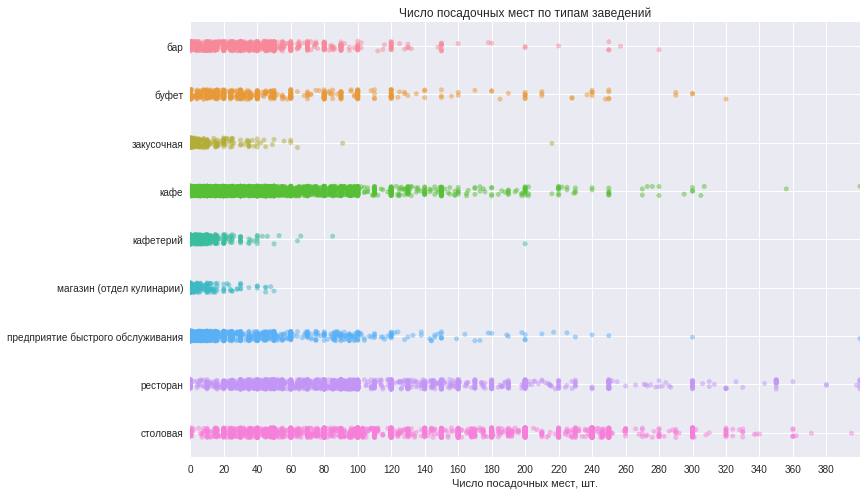

In [46]:
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(y="object_type", x="number", data=rest_data.sort_values(by='object_type'), alpha=0.5)
ax.set(title = f'Число посадочных мест по типам заведений',
       xlabel='Число посадочных мест, шт.',
       ylabel='',
       xticks=[x for x in range(0, 400, 20)],
       xlim=(0,400))
ax.grid(True)
plt.show()

In [47]:
(rest_data[rest_data['chain'] == 1]
 .groupby('object_name', as_index=False)
 .agg({'object_type':'nunique'})
 .sort_values(by='object_type', ascending=False)
 .query('object_type > 1'))

,object_name,object_type
243,милти,7
154,донер кебаб,5
271,папа джонс,5
365,сушиstore,5
329,скалка,5
...,...,...
429,шаурма 24,2
427,шарлима,2
114,вьеткафе,2
140,две палочки,2


Заведения с различными типами рассмотрим поподробнее.

In [48]:
rest_data.query('object_name == "макдоналдс"')['object_type'].value_counts()

предприятие быстрого обслуживания    117
ресторан                              31
кафе                                  25
Name: object_type, dtype: int64

In [49]:
rest_data.query('object_name == "хлебница"')['object_type'].value_counts()

кафетерий                            4
магазин (отдел кулинарии)            3
кафе                                 3
предприятие быстрого обслуживания    2
закусочная                           1
Name: object_type, dtype: int64

In [50]:
rest_data.query('object_name == "якитория"')['object_type'].value_counts()

ресторан    30
кафе        21
Name: object_type, dtype: int64

**Допущение №3**

1. Большинство заведений в рамках сети имеют единый тип.
2. Присваиваем всем заведениям сети самый популярный тип.

In [51]:
# перечень имён объектов, у которых более чем два типа
chain_object_list = (rest_data[rest_data['chain'] == 1]
                     .groupby('object_name', as_index=False)
                     .agg({'object_type':'nunique'})
                     .sort_values(by='object_type', ascending=False)
                     .query('object_type > 1')['object_name'])

In [52]:
# для таких объектов присваиваем самый популярный (или первый по списку) тип
for chain_object in chain_object_list:
    (rest_data.loc[rest_data['object_name'] == chain_object,
          ['object_type']]) = (rest_data
                               .query('object_name == @chain_object')
                               ['object_type']
                               .value_counts()
                               .index[0])

In [53]:
rest_data.query('object_name == "донер кебаб"')['object_type'].value_counts()

предприятие быстрого обслуживания    56
Name: object_type, dtype: int64

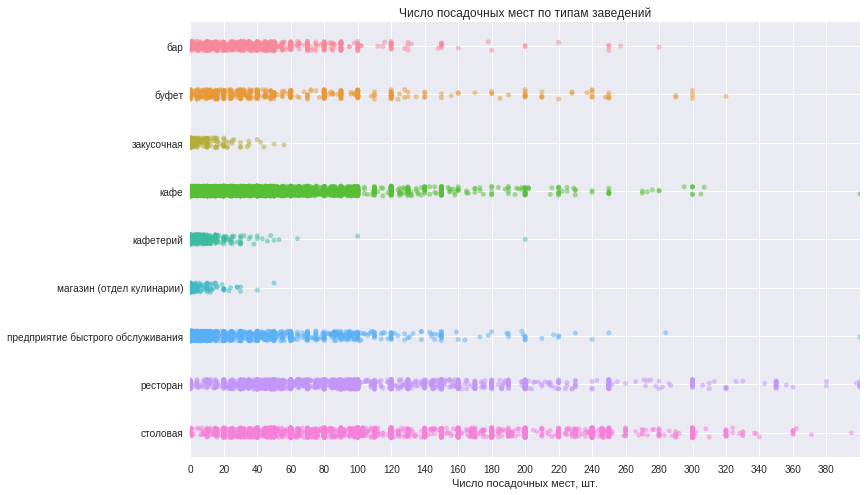

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(y="object_type", x="number", data=rest_data.sort_values(by='object_type'), alpha=0.5)
ax.set(title = f'Число посадочных мест по типам заведений',
       xlabel='Число посадочных мест, шт.',
       ylabel='',
       xticks=[x for x in range(0, 400, 20)],
       xlim=(0,400))
ax.grid(True)
plt.show()

**Промежуточный вывод**

Всем сетевым заведениям присвоен единый тип в рамках сети

#### Число посадочных мест

Изучим данные по числу посадочных мест, построим сводный boxplot.

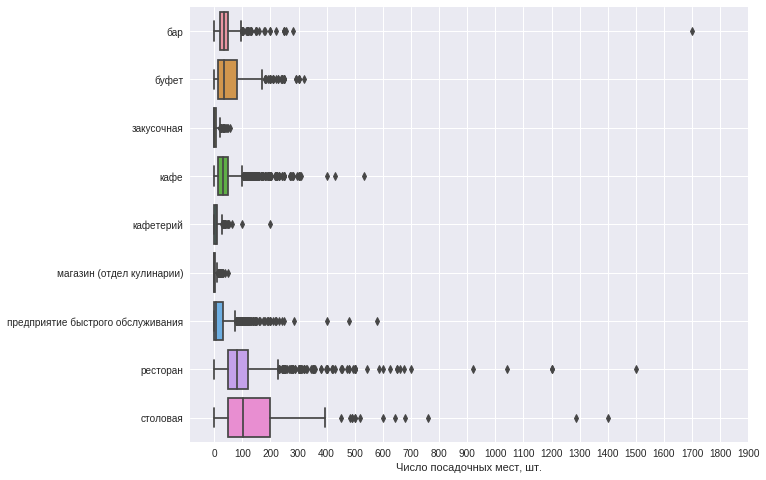

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=rest_data.sort_values(by='object_type'), y='object_type', x='number', orient='h')
ax.set(xlabel='Число посадочных мест, шт.',
       ylabel='',
       xticks=([x for x in range(0,2000,100)]))
ax.grid(True)

Уберём вылеты в пределах полутора размахов от 1 и 3 квартиля.

In [56]:
flier_id = []  # составим перечень заведений, которые отнесём к выбросам.
for object_type in rest_data['object_type'].unique():
    q3 = rest_data[rest_data['object_type'] == object_type]['number'].quantile(0.75)
    q1 = rest_data[rest_data['object_type'] == object_type]['number'].quantile(0.25)
    iqr = q3 - q1
    flier_id += list(rest_data[(rest_data['object_type'] == object_type)
                               & ((rest_data['number'] > q3 + 1.5*iqr)
                                  | (rest_data['number'] < q1 - 1.5*iqr))]['id'])

In [57]:
rest_data = rest_data[~rest_data['id'].isin(flier_id)]  # убираем выбросы

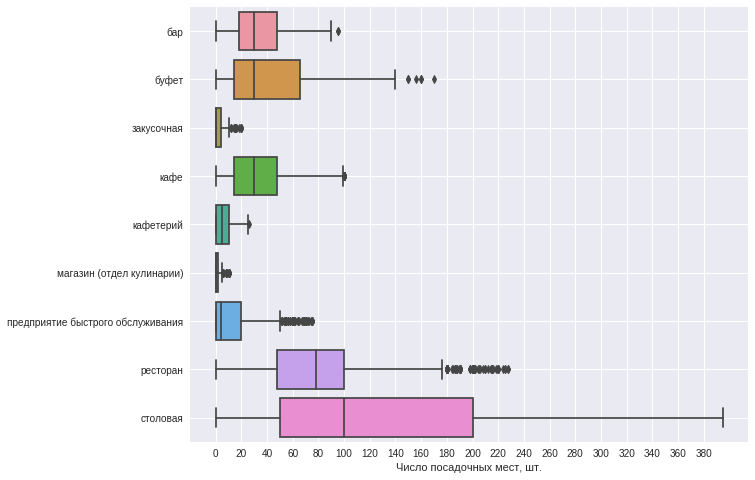

In [58]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=rest_data.sort_values(by='object_type'), y='object_type', x='number', orient='h')
ax.set(xlabel='Число посадочных мест, шт.',
       ylabel='',
       xticks=([x for x in range(0,400,20)]))
ax.grid(True)

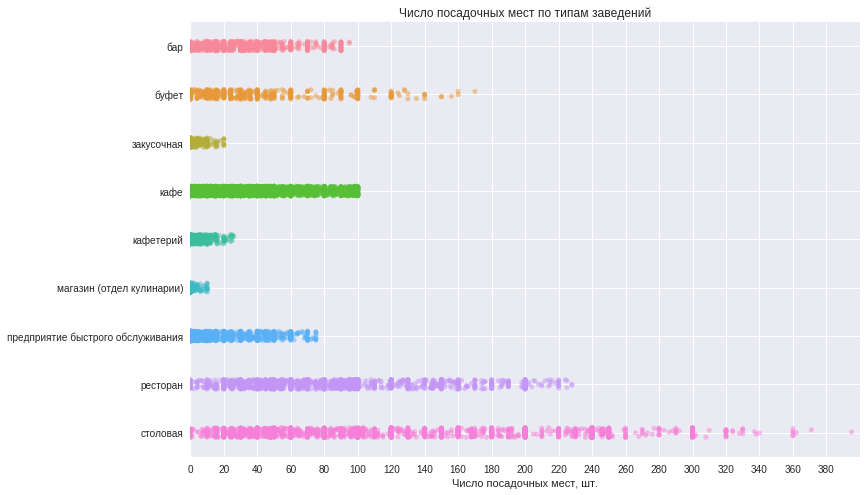

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(y="object_type", x="number", data=rest_data.sort_values(by='object_type'), alpha=0.5)
ax.set(title = f'Число посадочных мест по типам заведений',
       xlabel='Число посадочных мест, шт.',
       ylabel='',
       xticks=[x for x in range(0, 400, 20)],
       xlim=(0,400))
ax.grid(True)
plt.show()

In [60]:
rest_data.groupby('object_type')['number'].median()

object_type
бар                                   30
буфет                                 30
закусочная                             0
кафе                                  30
кафетерий                              5
магазин (отдел кулинарии)              0
предприятие быстрого обслуживания      4
ресторан                              78
столовая                             100
Name: number, dtype: int64

In [61]:
rest_data.query('number == 0')['object_type'].value_counts()

предприятие быстрого обслуживания    797
кафе                                 338
закусочная                           161
магазин (отдел кулинарии)            104
кафетерий                             94
буфет                                 58
ресторан                              25
бар                                   25
столовая                              19
Name: object_type, dtype: int64

In [62]:
rest_data.query('number < 10 and object_type in ["ресторан", "столовая"]')

,id,object_name,chain,object_type,address,number
70,53084,специализированный цех магнолия,0,столовая,"город Москва, улица Барклая, дом 16, корпус 1",7
206,150836,гбоу школа № 1468,0,столовая,"город Москва, Волгоградский проспект, дом 17, ...",0
438,154690,столовая,0,столовая,"город Москва, Коломенская улица, дом 5",5
634,29839,специализированный цех вито 1,0,столовая,"город Москва, Магнитогорская улица, дом 19",1
776,53083,специализированный цех магнолия,0,столовая,"город Москва, Новозаводская улица, дом 25, кор...",7
...,...,...,...,...,...,...
14769,213690,русский,1,ресторан,"город Москва, Пресненская набережная, дом 12",4
14967,210764,дейли шеф,0,ресторан,"город Москва, город Московский, улица Хабарова...",0
15252,222677,чайхона № 1,1,ресторан,"город Москва, Мячковский бульвар, дом 3А",0
15253,214872,чайхона № 1,1,ресторан,"город Москва, Кутузовский проспект, дом 57",0


**Допущение №4**
1. В ресторанах, столовых и кафе всегда должны быть посадочные места.
2. Примем, что в кафе должно быть минимум 8 посадочных мест.
3. Примем, что в ресторане должно быть не менее 20 посадочных мест.
4. Примем, что в столовой должно быть не менее 30 посадочных мест.
5. Для остальных заведений сказать однозначно что-то сложно, для них границ выставлять не будем.

Если мест меньше, то заполняем медианным значением.

In [63]:
for key, value in {'кафе':8, 'ресторан':20, 'столовая':30}.items():
    rest_data.loc[(rest_data['object_type'] == key)
                  & (rest_data['number'] < value),
                  ['number']] = int((rest_data[rest_data['number'] >= value]
                                     .groupby('object_type')['number']
                                     .median().loc[key]))

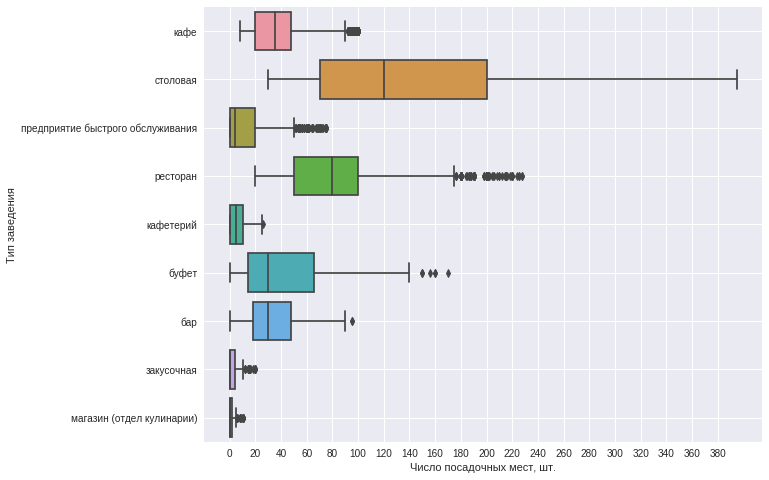

In [64]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=rest_data, y='object_type', x='number', orient='h')
ax.set(xlabel='Число посадочных мест, шт.',
       ylabel='Тип заведения',
       xticks=([x for x in range(0,400,20)]))
ax.grid(True)

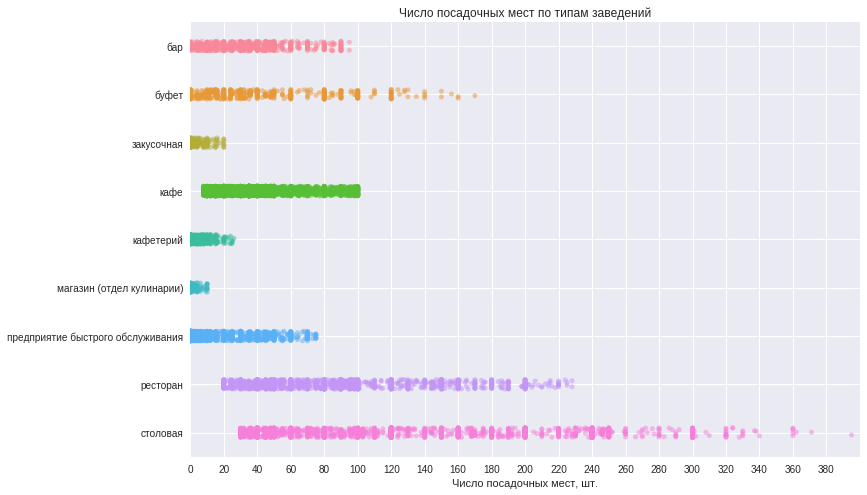

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(y="object_type", x="number", data=rest_data.sort_values(by='object_type'), alpha=0.5)
ax.set(title = f'Число посадочных мест по типам заведений',
       xlabel='Число посадочных мест, шт.',
       ylabel='',
       xticks=[x for x in range(0, 400, 20)],
       xlim=(0,400))
ax.grid(True)
plt.show()

### Вывод

1. Выпонена загрузка и предобработка данных.
2. Выявлено, что наименования заведений не имеют стандартизированной записи и содержат скрытые дубликаты.
3. Часть скрытых дубликатов было обработано, исходя из названий сетевых заведений. Для этого был создан словарь корректных наименований, в соответствии с которым осуществлялся поиск подстроки и последующее присвоение корректного наименования.
4. Также были обработаны строки, содержащие французские кавычки ("ёлочки"). Оставлено только содержимое в кавычках.
5. Выявлены заведения, не обозначенные как сетевые, соответственно, тип измененён на сетевое.
6. Сетевые заведения приведены к единому типу.
7. Убраны выбросы по количеству посадочных мест.

При анализе сделаны следующие допущения:
1. Сеть состоит минимум из трёх заведений
2. Примем за истину на данном этапе типы заведений, указанные в столбце `object_type`
3. Большинство заведений в рамках сети имеют единый тип.
4. Присваиваем всем заведениям сети самый популярный тип.
5. В ресторанах, столовых и кафе всегда должны быть посадочные места.
    1. Примем, что в кафе должно быть минимум 8 посадочных мест.
    2. Примем, что в ресторане должно быть не менее 20 посадочных мест.
    3. Примем, что в столовой должно быть не менее 30 посадочных мест.
    4. Для остальных заведений сказать однозначно что-то сложно, для них границ выставлять не будем.

## Анализ данных

### Соотношение объектов общественного питания по количеству

In [66]:
object_types = (rest_data['object_type'].value_counts()
                / rest_data['object_type'].value_counts().sum()
                * 100)
object_types

кафе                                 40.926799
столовая                             17.620122
ресторан                             14.004511
предприятие быстрого обслуживания    13.430388
бар                                   5.228624
буфет                                 3.608776
кафетерий                             2.303329
закусочная                            1.770214
магазин (отдел кулинарии)             1.107238
Name: object_type, dtype: float64

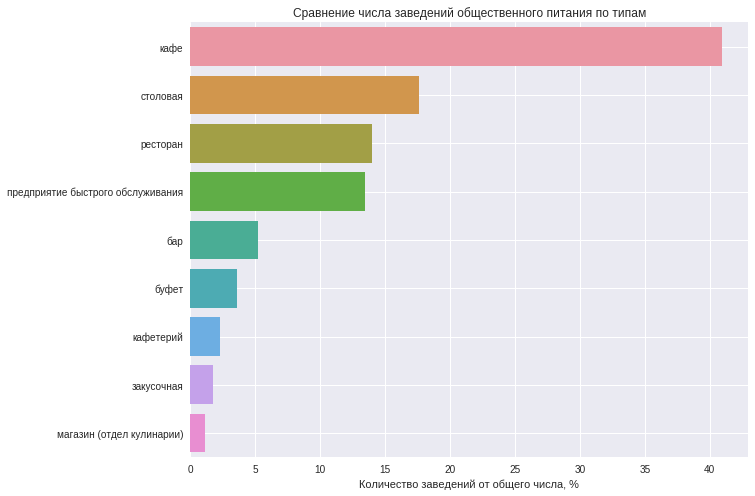

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(y=object_types.index, x=object_types, orient='h')
ax.set(title = 'Сравнение числа заведений общественного питания по типам',
       xlabel='Количество заведений от общего числа, %',
       ylabel='')
ax.grid(True)

**Вывод**

1. Кафе с большым отрывом является самым популярным видом заведения общественного питания (41 % заведений). Это можно объяснить размытостью определения и распростанённостью формата.
2. На втором месте (17%) оказались столовые, что объясняется большим количеством школьных столовых.
3. Предприятия быстрого обслуживания и рестораны делят третье место (13%).

### Соотношение сетевых и несетевых заведений

In [68]:
object_types = (rest_data.query('chain == 1')['object_type'].value_counts().sort_values()
                / rest_data['object_type'].value_counts().sort_values()
                * 100).sort_values(ascending=False)
object_types

предприятие быстрого обслуживания    53.740458
кафе                                 33.767535
ресторан                             24.255735
кафетерий                            13.353116
магазин (отдел кулинарии)            12.345679
закусочная                           10.424710
бар                                   9.411765
столовая                              9.270753
буфет                                 8.143939
Name: object_type, dtype: float64

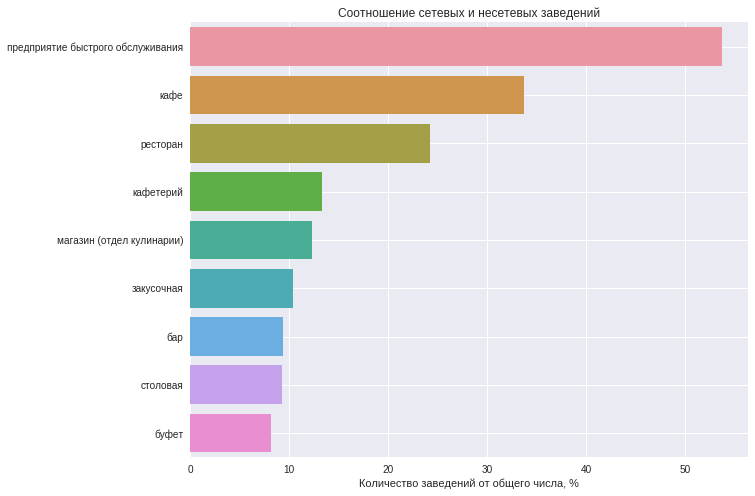

In [69]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=object_types, y=object_types.index)
ax.set(title = 'Соотношение сетевых и несетевых заведений',
       xlabel='Количество сетевых заведений от общего числа заведений такого типа, %',
       ylabel='')
ax.grid(True)

**Выводы**

К той или иной сети относятся 55 % предприятий быстрого обслуживания, 35 % кафе и 25 % ресторанов.

### Сравнение числа сетевых заведений общественного питания по типам

In [70]:
object_types = (rest_data.query('chain == 1')['object_type'].value_counts()
                / rest_data.query('chain == 1')['object_type'].value_counts().sum()
                * 100)
object_types

кафе                                 50.285999
предприятие быстрого обслуживания    26.262124
ресторан                             12.360109
столовая                              5.943795
бар                                   1.790599
кафетерий                             1.119125
буфет                                 1.069386
закусочная                            0.671475
магазин (отдел кулинарии)             0.497389
Name: object_type, dtype: float64

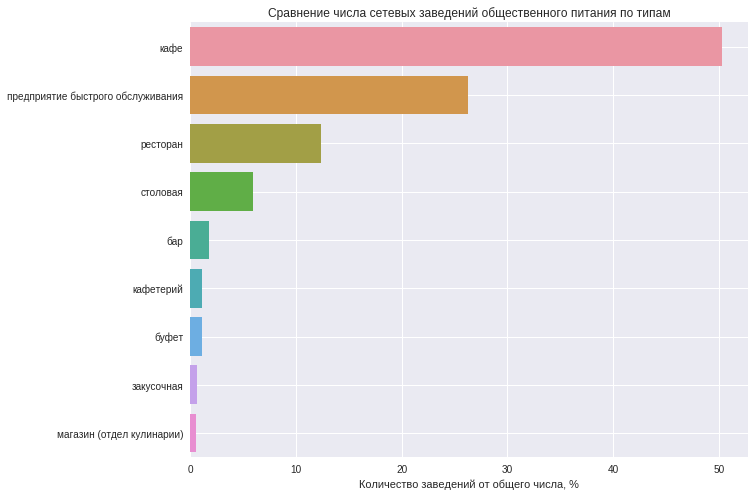

In [71]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(y=object_types.index, x=object_types, orient='h')
ax.set(title = 'Сравнение числа сетевых заведений общественного питания по типам',
       xlabel='Количество заведений от общего числа, %',
       ylabel='')
ax.grid(True)

**Выводы**

1. Для сетевых заведений картина изменилась. Ушли школьные столовые.
2. Первое место по прежнему занимают кафе (51 %)
3. На втором месте (27%) оказались предприятия быстрого обслуживания, представленные большим числом заведений по типу KFC или Бургер Кинга.
4. На третьем месте остались рестораны (10%)
5. С небольшим отставанием идут столовые (6%)
6. Остальные виды заведений представлены незначительно.

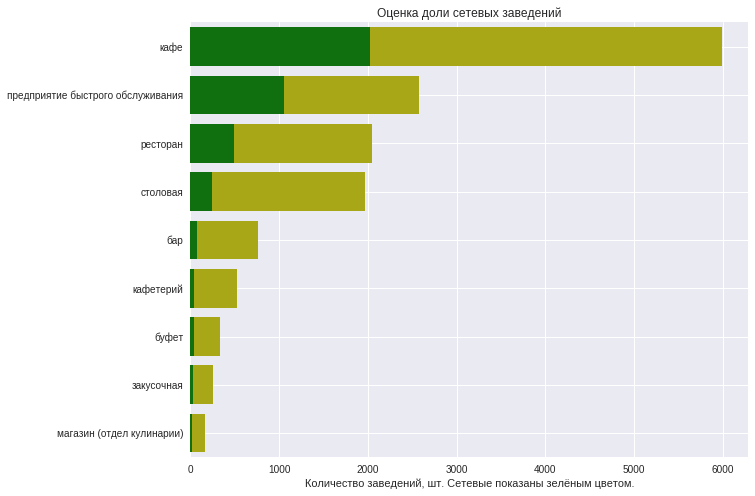

In [72]:
object_types = rest_data['object_type'].value_counts()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(y=object_types.index, x=object_types, orient='h', color='y')

object_types = rest_data.query('chain == 1')['object_type'].value_counts()
ax = sns.barplot(y=object_types.index, x=object_types, orient='h', color='g')

ax.set(title = 'Оценка доли сетевых заведений',
       xlabel='Количество заведений, шт. Сетевые показаны зелёным цветом.',
       ylabel='')
ax.grid(True)

### Анализ числа посадочных мест в сетевых заведениях

Определимся с понятиями много-мало. Примем, что мало - это меньше медианы, много - это больше или равно медиане.

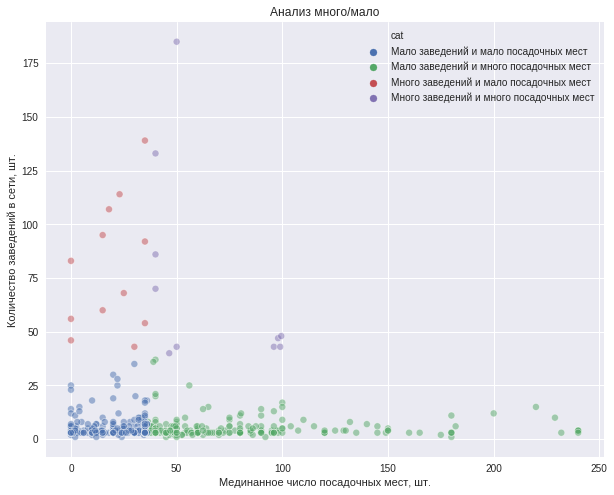

In [73]:
def object_cat_maker(row, median_1, median_2):
    if (row['id'] < median_1) and (row['number'] < median_2):
        return 'Мало заведений и мало посадочных мест'
    if (row['id'] >= median_1) and (row['number'] < median_2):
        return 'Много заведений и мало посадочных мест'
    if (row['id'] < median_1) and (row['number'] >= median_2):
        return 'Мало заведений и много посадочных мест'
    if (row['id'] >= median_1) and (row['number'] >= median_2):
        return 'Много заведений и много посадочных мест'
    return 'Прочее'
    

number_median = rest_data['number'].median()
chain_number = (rest_data
                    .query('chain == 1')
                    .groupby(['object_name'])
                    .agg({'id':'count', 'number':'median'}))    
chain_median = chain_number['number'].median()
chain_number['cat'] = (chain_number.apply(lambda x: object_cat_maker(x,
                                                                     number_median,
                                                                     chain_median),
                                          axis=1))
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(data=chain_number, x='number', y='id', hue='cat', alpha=0.5)
ax.set(title = f'Анализ много/мало',
       xlabel='Мединанное число посадочных мест, шт.',
       ylabel='Количество заведений в сети, шт.')
plt.show()

**Выводы**

1. Если сеть представлена множеством заведений, то посадочных мест будет меньше 50.
2. Большая часть сетей представлено менее чем 10 заведениями, при этом число посадочных мест может варьироваться в широких пределах от 0 до 100.

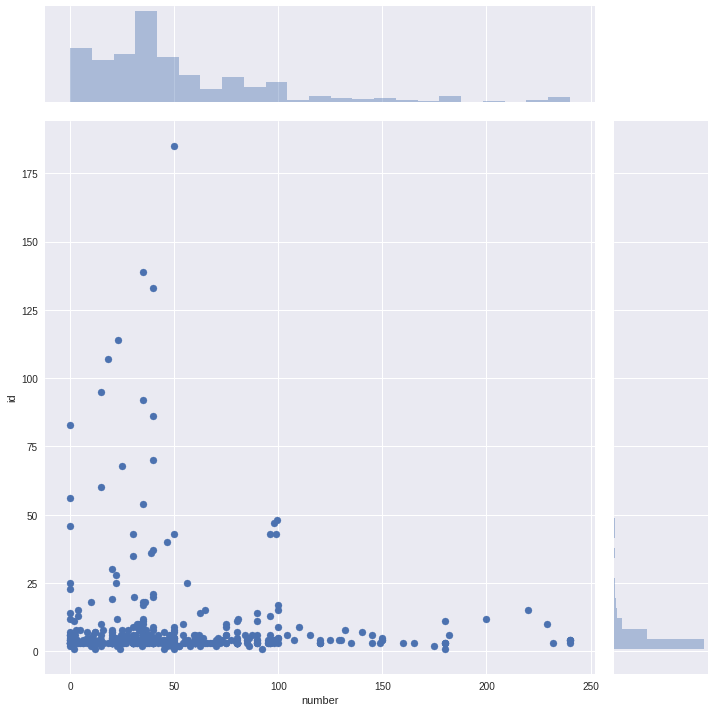

In [74]:
sns.jointplot(data=chain_number, x='number', y='id', kind='scatter', height=10)
plt.show()

### Анализ среднего числа посадочных мест

In [75]:
object_types = rest_data.groupby('object_type')['number'].mean().sort_values(ascending=False)

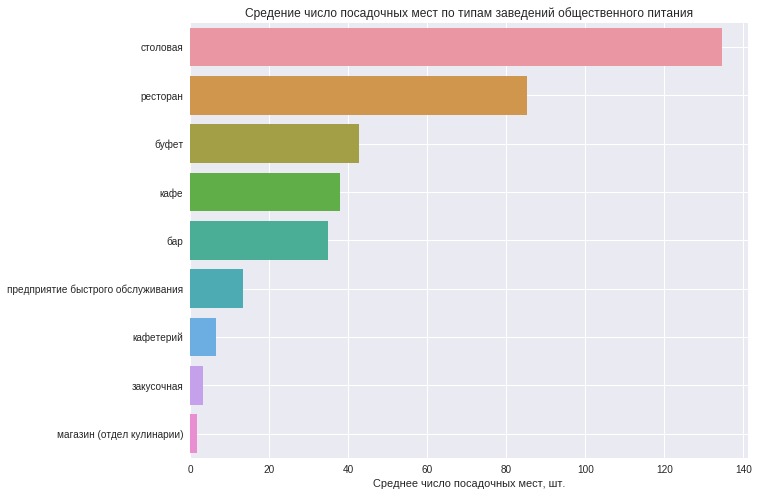

In [76]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(y=object_types.index, x=object_types, orient='h')
ax.set(title = 'Средение число посадочных мест по типам заведений общественного питания',
       xlabel='Среднее число посадочных мест, шт.',
       ylabel='')
ax.grid(True)
plt.show()

**Выводы**



1. Самое большое число посадочных мест характерно для столовых.
2. На втором месте рестораны оказались рестораны.
3. Наличие на третьем месте буфетов можно объяснить скорее всего ошибкой в классификации (непонятно, где буфет, а где столовая).
4. Кафе занимает четвёртое место примерно на одном уровне с барами.

### Топ 10 улиц по количеству объектов

Чтобы разобраться с улицами подготовим функцию, позволяющую их отобрать.

In [77]:
def street_finder(address):
    
    street_list_type = ['улица', #  список возможных видов улиц
                        'проспект',
                        'шоссе',
                        'проезд',
                        'бульвар',
                        'переулок',
                        'площадь',
                        'набережная',
                        'вал',
                        'аллея',
                        'тупик',
                        'линия',
                        'квартал',
                        'деревня',
                        'микрорайон',
                        'мост',
                        'парк',
                        'посёлок']
    
    address = address.split(',')
    for address_part in address:
        for street in street_list_type:
            if street in address_part.lower():
                return address_part.strip()
    return np.nan

rest_data['street'] = rest_data['address'].apply(street_finder)

Загрузка внешних данных

In [78]:
from io import BytesIO
import requests

spreadsheet_id = '1tA-pTHlei-yKzzg3-HAkPR9-2kTaOgbx3Kb3Aa_6nqQ'
file_name = f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=csv'
r = requests.get(file_name)
area_data = pd.read_csv(BytesIO(r.content))
area_data.columns = ['street_name','area_id', 'okrug', 'area']
area_data

,street_name,area_id,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


In [79]:
rest_data = rest_data.merge(area_data[['street_name', 'area']], how='left', left_on='street', right_on='street_name').drop('street_name', axis=1)

In [80]:
top_10_street = rest_data.groupby('street').agg({'id':'nunique', 'area':'first'}).sort_values(by='id', ascending=False).iloc[:10,:]

In [81]:
top_10_street.columns = ['object_ttl', 'area']
top_10_street

,object_ttl,area
street,,
проспект Мира,177,Алексеевский район
Профсоюзная улица,175,Академический район
Ленинградский проспект,166,Район Аэропорт
Пресненская набережная,156,Пресненский район
Варшавское шоссе,155,Район Чертаново Центральное
Ленинский проспект,142,Район Проспект Вернадского
проспект Вернадского,127,Район Проспект Вернадского
Кутузовский проспект,110,Район Дорогомилово
Кировоградская улица,104,Район Чертаново Центральное


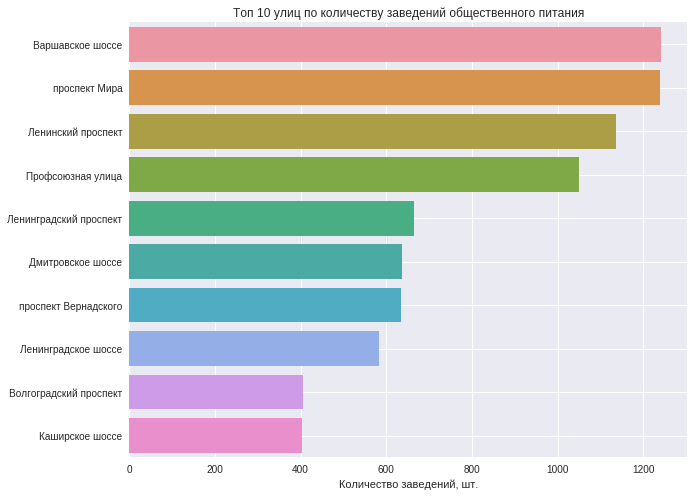

In [82]:
top_10_street = rest_data['street'].value_counts()[:10]


fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(y=top_10_street.index, x=top_10_street, orient='h')
ax.set(title = 'Топ 10 улиц по количеству заведений общественного питания',
       xlabel='Количество заведений, шт.',
       ylabel='')
ax.grid(True)
plt.show()

In [83]:
# протяженность улиц
street_lenght = {'Варшавское шоссе': 22.5,
                 'проспект Мира': 8.9,
                 'Ленинский проспект': 14,
                 'Профсоюзная улица': 9.3,
                 'Ленинградский проспект': 5.6,
                 'Дмитровское шоссе': 15.5,
                 'проспект Вернадского': 8,
                 'Ленинградское шоссе': 19.7,
                 'Волгоградский проспект': 11.3,
                 'Каширское шоссе': 12}
street_lenght = pd.DataFrame.from_dict(data=street_lenght, orient='index', columns=['street_lenght'])

In [84]:
top_10_street = top_10_street.to_frame()
top_10_street = top_10_street.join(street_lenght)
top_10_street.columns = ['objects_ttl', 'street_lenght']

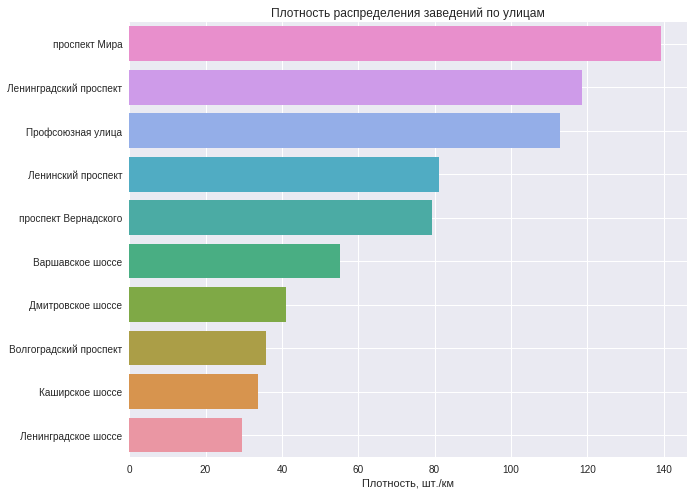

In [85]:
top_10_street['objects_density_per_km'] = top_10_street['objects_ttl'] / top_10_street['street_lenght']
top_10_street = top_10_street.sort_values(by='objects_density_per_km')
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(y=top_10_street.index, x=top_10_street['objects_density_per_km'], orient='h')
ax.set(title = 'Плотность распределения заведений по улицам',
       xlabel='Плотность, шт./км',
       ylabel='')
ax.invert_yaxis()
ax.grid(True)
plt.show()

**Выводы**

* Больше всего заведений общественного питания на радиальных улицах, скорее всего это обусловлено в том числе большой протяженностью этих улиц.

* При этом выделяется юго-западная часть Москвы. Данный момент можно объяснить направлением в сторону Большой Москвы.

|Улица|Район|
|:----|:----|
|проспект Мира|Алексеевский район|
|Профсоюзная улица|Академический район|
|Ленинградский проспект|Район Аэропорт|
|Пресненская набережная|Пресненский район|
|Варшавское шоссе|Район Чертаново Центральное|
|Ленинский проспект|Район Проспект Вернадского|
|проспект Вернадского|Район Проспект Вернадского|
|Кутузовский проспект|Район Дорогомилово|
|Кировоградская улица|Район Чертаново Центральное|
|Ходынский бульвар|Хорошевский район|



### Улицы с одним объектом общестенного питания

In [86]:
# Районы, в которых расположены улицы с одним объектом общественного питания
(rest_data
 .groupby(['street'])
 .agg({'id':'nunique', 'area':'first'})
 .query('id == 1')['area']
 .unique())

array(['Район Аэропорт', 'Басманный район', 'Район Свиблово',
       'Рязанский район', 'Район Якиманка', nan, 'Район Хамовники',
       'Район Соколиная Гора', 'Даниловский район',
       'Красносельский район', 'Таганский район', 'Район Лефортово',
       'Район Печатники', 'Район Замоскворечье', 'Хорошевский район',
       'Район Арбат', 'Алексеевский район', 'Район Текстильщики',
       'Район Ростокино', 'Район Раменки', 'Район Хорошево-Мневники',
       'Район Покровское-Стрешнево', 'Район Марьина роща',
       'Район Сокольники', 'Район Богородское', 'Нижегородский район',
       'Тверской район', 'Лосиноостровский район', 'Район Преображенское',
       'Район Ново-Переделкино', 'Район Измайлово',
       'Район Восточное Измайлово', 'Район Беговой', 'Донской район',
       'Район Гольяново', 'Войковский Район', 'Савеловский район',
       'Район Филевский Парк', 'Район Перово', 'Район Чертаново Южное',
       'Южнопортовый Район', 'Головинский район', 'Район Южное Бутово',
     

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

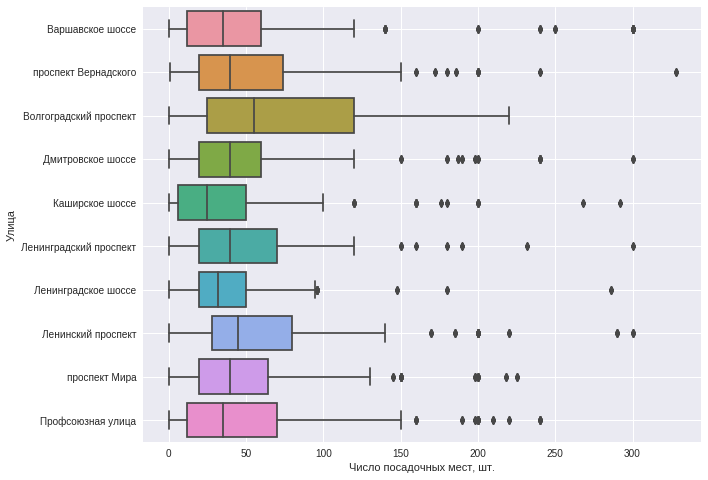

In [87]:
rest_data_top_10 = rest_data[rest_data['street'].isin(top_10_street.index)]
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(data=rest_data_top_10, y='street', x='number', orient='h')
ax.set(xlabel='Число посадочных мест, шт.',
       ylabel='Улица',)
ax.grid(True)

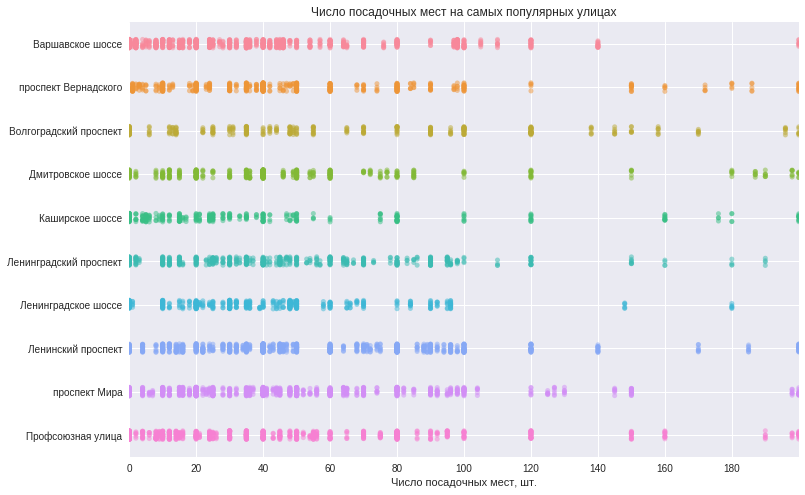

In [88]:
fig, ax = plt.subplots(figsize=(12,8))
sns.stripplot(y='street', x='number', data=rest_data_top_10, alpha=0.5)
ax.set(title = f'Число посадочных мест на самых популярных улицах',
       xlabel='Число посадочных мест, шт.',
       ylabel='',
       xticks=[x for x in range(0, 200, 20)],
       xlim=(0,200))
ax.grid(True)
plt.show()

**Выводы**

1. На улицах с большим количеством объектов общественного питания в заведениях около 40 посадочных мест.
2. Большая часть заведений находится в диапазонеот 20 до 70 посадочных мест.

## Выводы

1. Самые распространённые виды заведений: кафе (41 %), столовые (17 %), предприятия быстрого обслуживания и рестораны (по 13%).
2. К той или иной сети относятся 55 % предприятий быстрого обслуживания, 35 % кафе и 25 % ресторанов.
3. Самые распространённые виды сетевых заведений: кафе (51 %), предприятия быстрого обслуживания (27%), рестораны (10%) и столовые (6 %).
4. Сетевые заведения обычно представлены 10 филиалами, при этом число посадочных мест в них может колебаться от 0 до 100. Это объясняется разными видами заведений.
5. Если заведения представлены большой сетью, то число посадочных мест в них обычно не более 50.
6. В среднем наибольшее число посадочных мест в столовых (130 мест), на втором месте рестораны (~ 80 мест), на третьем месте кафе, буфеты и бары (~40 мест).
7. Больше всего заведений на улицах:
|Улица|Район|Количество заведений|
|:----|:----|----:|
|проспект Мира|Алексеевский район|177|
|Профсоюзная улица|Академический район|175|
|Ленинградский проспект|Район Аэропорт|166|
|Пресненская набережная|Пресненский район|156|
|Варшавское шоссе|Район Чертаново Центральное|155|
|Ленинский проспект|Район Проспект Вернадского|142|
|проспект Вернадского|Район Проспект Вернадского|127|
|Кутузовский проспект|Район Дорогомилово|110|
|Кировоградская улица|Район Чертаново Центральное|104|
|Ходынский бульвар|Хорошевский район|102|
8. На улицах с большим количеством объектов общественного питания в заведениях около 40 посадочных мест.
9. Большая часть заведений находится в диапазонеот 20 до 70 посадочных мест.

Презентация: <https://drive.google.com/file/d/1_KKj3CQxSjUoiw6UhVpQL9ngMbvqaITD/view?usp=sharing> 